# Introduction to scvi-tools
In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi_tutorials/blob/dev/api_overview.ipynb)

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --upgrade jsonschema
    !pip install git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

import scvi
import scanpy as sc

Requirement already up-to-date: jsonschema in /usr/local/lib/python3.6/dist-packages (3.2.0)
     |████████████████████████████████| 3.2MB 7.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 2.4MB 41.9MB/s 
     |████████████████████████████████| 8.7MB 12.4MB/s 
     |████████████████████████████████| 7.7MB 53.3MB/s 
     |████████████████████████████████| 112kB 52.4MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=196bee9b6a057fab8744d70bb8317e7144b4667925af643586276bc4a9023cb6
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.13-cp36-none-any.whl size=24069 sha256=c4f401623e757c9ff18f542a69e59e4a8ecf0f5fcd6bce4f9287b9dcb7a2ae0b
  Stored in directory: /root/.cache/pip/

## Loading and preparing data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on [data loading](data_loading.ipynb) for more examples.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

<div class="alert alert-info">

Important

All scvi-tools models require AnnData objects as input. 

</div>

In [ ]:
adata = scvi.data.cortex(run_setup_anndata=False)

INFO      Downloading file at /content/data/expression.bin                      
INFO      Loading Cortex data from /content/data/expression.bin                 
INFO      Finished loading Cortex data                                          


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [ ]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, among others, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specific, scvi-tools models require the raw counts.

</div>

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (here, genes) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial.

In [ ]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3"
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.



In [ ]:
scvi.data.setup_anndata(adata, layer="counts")

INFO      No batch_key inputted, assuming all cells are same batch              
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Successfully registered anndata object containing 3005 cells, 2000    
          genes, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For full list of options, see the documentation.

In [ ]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [ ]:
model

SCVI Model with params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [ ]:
model.train()

INFO      KL warmup for 400 epochs                                              


Output()

INFO      Training time:  113 s. / 400 epochs                                   


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [ ]:
model.save("my_model/")

In [ ]:
model = scvi.model.SCVI.load(adata, "my_model/", use_cuda=True)

## Obtaining model outputs

In [ ]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [ ]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [ ]:
adata_subset = adata[adata.obs.cell_type == "interneurons"]
latent_subset = model.get_latent_representation(adata_subset)

INFO      Received view of anndata, making copy.                                


In [ ]:
denoised = model.get_normalized_expression(adata_subset, library_size=10e4)
denoised.iloc[:5, :5]

INFO      Received view of anndata, making copy.                                


,Tshz1,2310042E22Rik,Sema3c,Jam2,Klhl13
0,34.172291,11.900369,226.214600,36.507690,103.343269
1,31.713140,28.055269,204.428802,13.279721,106.054047
2,18.533686,31.503839,612.331909,78.135330,202.348083
3,25.587479,51.464203,241.749634,18.102861,148.764862
4,68.990685,26.903820,157.888565,10.193274,138.968933


Let's store the normalized values back in the anndata.

In [ ]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

... storing 'precise_labels' as categorical
... storing 'cell_type' as categorical


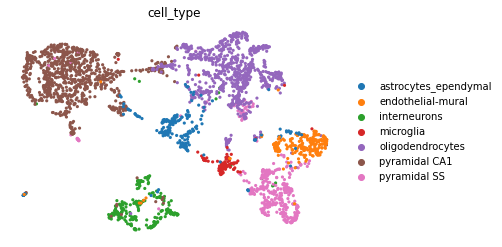

In [ ]:
sc.pl.umap(
    adata, 
    color="cell_type", 
    frameon=False,
)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [ ]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI")

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see TODO.

In [ ]:
adata.obs.cell_type.head()

0    interneurons
1    interneurons
2    interneurons
3    interneurons
4    interneurons
Name: cell_type, dtype: category
Categories (7, object): [astrocytes_ependymal, endothelial-mural, interneurons, microglia, oligodendrocytes,
                         pyramidal CA1, pyramidal SS]

For example, a 1-vs-1 DE test is as simple as:

In [ ]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="oligodendrocytes", 
    group2="pyramidal CA1"
)
de_df.head()

Output()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison
Icam5,1.0000,0.0000,18.420681,0.000086,0.002353,-5.376781,-5.626368,1.348573,-8.737123,0.671820,0.115854,4.640043,0.080488,0.926518,0.539940,27.065977,oligodendrocytes vs pyramidal CA1
Mmd,1.0000,0.0000,18.420681,0.000168,0.004009,-5.045812,-5.215079,1.250184,-7.987005,0.296421,0.229268,7.690096,0.137805,0.977636,1.022028,45.961216,oligodendrocytes vs pyramidal CA1
Slc8a1,0.9998,0.0002,8.516943,0.000605,0.010312,-4.304520,-4.428328,1.018000,-7.192300,-0.163869,1.060976,20.086262,0.352439,0.991480,4.516073,115.609520,oligodendrocytes vs pyramidal CA1
Dgkg,0.9998,0.0002,8.516943,0.000261,0.004208,-4.193096,-4.263711,0.982092,-7.841075,0.419635,0.126829,8.155484,0.065854,0.975506,0.540623,51.665966,oligodendrocytes vs pyramidal CA1
Ddn,0.9998,0.0002,8.516943,0.000260,0.003778,-4.110078,-4.163136,1.127335,-8.934053,1.917148,0.218293,7.184238,0.098780,0.957401,0.879565,44.778248,oligodendrocytes vs pyramidal CA1


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [ ]:
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

Output()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison
Cml5,0.9948,0.0052,5.253881,0.000679,0.000012,7.754991,7.963428,3.569530,-6.690024,18.151081,0.156250,0.005034,0.062500,0.003955,1.048622,0.019568,astrocytes_ependymal vs Rest
Slc1a3,0.9942,0.0058,5.144079,0.015234,0.000961,4.861070,4.972892,1.940111,-2.869020,10.098665,30.156250,1.977346,0.982143,0.281194,211.173355,9.182883,astrocytes_ependymal vs Rest
Gja1,0.9926,0.0074,4.898846,0.006811,0.000438,5.315531,5.546753,2.188639,-2.315550,11.194177,12.705358,0.822006,0.977679,0.186624,88.167435,3.939137,astrocytes_ependymal vs Rest
Aqp4,0.9924,0.0076,4.871977,0.008168,0.000467,4.673203,4.821848,1.884676,-3.284332,9.616211,20.973215,0.598706,0.937500,0.112549,120.902222,2.687396,astrocytes_ependymal vs Rest
Obox6,0.9912,0.0088,4.724163,0.001497,0.000035,6.220726,6.289189,3.109761,-5.672326,15.472239,0.017857,0.002517,0.004464,0.001798,0.452080,0.017143,astrocytes_ependymal vs Rest


We now extract top markers for each cluster using the DE results.

In [ ]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

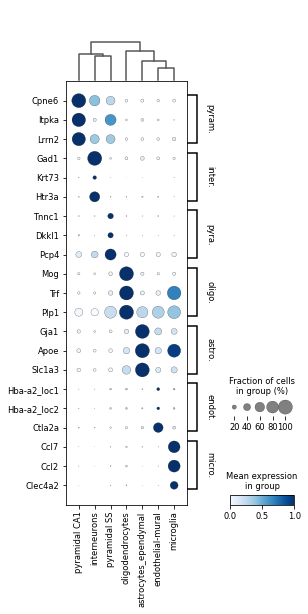

In [ ]:
sc.pl.dotplot(
    adata, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

         Falling back to preprocessing with `sc.pp.pca` and default params.


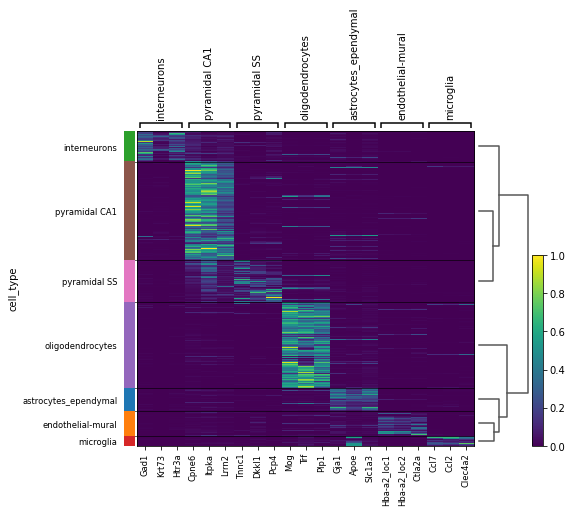

In [ ]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
)

## Logging information

Verbosity varies in the following way:

* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>